In [3]:
import os
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow import keras
from keras.datasets.cifar import load_batch
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel color images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![](https://github.com/jbscoggi/teaching/blob/master/Polytechnique/CSE204/artwork/cifar_images.png?raw=1)



In [5]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training: 
        - one-hot encoding;
        - normalization;
        - labels (list of strings associated to the one-hot encoding of `y`).
    """
    
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test  = keras.utils.to_categorical(y_test, 10)
    x_train = x_train.astype('float32') / 255
    x_test  = x_test.astype('float32') / 255
    return x_train, y_train, x_test, y_test, labels

In [6]:
x_train, y_train, x_test, y_test, labels = load_cifar_data()

170498071/170498071 [==============================] - 5s 0us/step


In [7]:
def show_first_n_images_in_categories(n: int, images: np.array, categories: np.array,
                                      labels: np.array, file_name: str = None):
    """Plots the first n images in each category from the image data.
    
    :param int n: number of images per category to plot
    :param numpy.array images: images as numerical data (x_*)
    :param numpy.array categories: the categories of each image in `images`
    :param numpy.array labels: the labels of categories 0 .. 9    
    :param str file_name: print figure to file (optional)
    """
    f, axes = plt.subplots(n, 10, figsize=(11, 8))
    # YOUR CODE HERE
    for i in range(10):
        count = 0
        for j, category in enumerate(categories[:, i]):
            if category == 1 and count < n:
                axes[count, i].imshow(images[j])
                axes[count, i].axis('off')
                if count == 0:
                    axes[count, i].set_title(labels[i])
                count += 1
            if count == n:
                break

    plt.show()

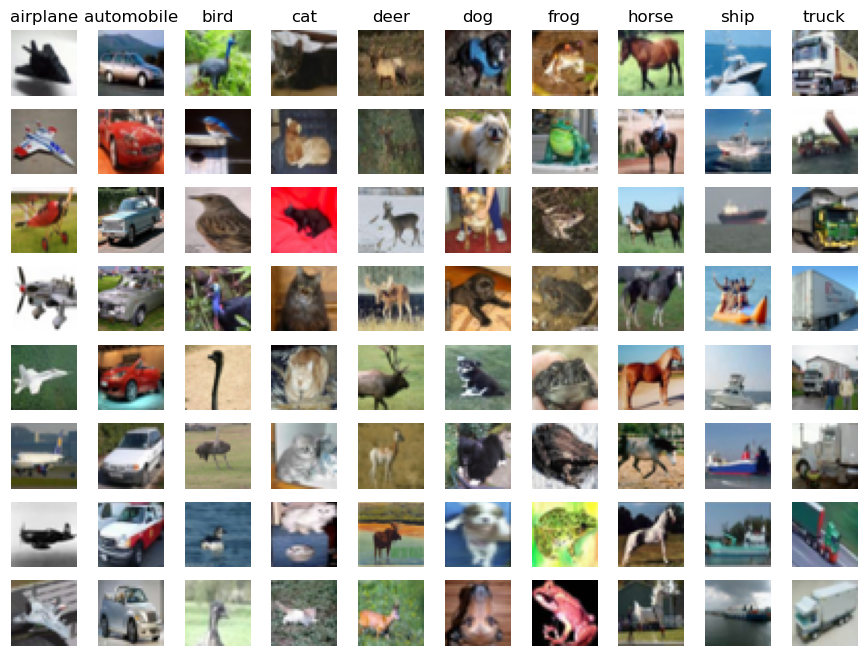

In [8]:
show_first_n_images_in_categories(8, x_train, y_train, labels)

In [21]:
def cnn_model(input_shape: tuple, num_classes: int):
    """
    Returns a compiled keras Conv2D model
    
    :param tuple input_shape: shape of ONE example as passed to the first layer
    :param int num_classes: number of output classes as passed to the last layer
    """
    
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
 
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def train_model(model, x: np.array, y: np.array,
                x_test: np.array, y_test: np.array,
                batch_size: int = 32, epochs: int = 10, file_name: str = None):
    """
    Trains the model on the given data.

    :param keras.sequential model: the instanciated model to train
    :param numpy.array x: the training data
    :param numpy.array y: the true values
    :param numpy.array x_test: the test data
    :param numpy.array y_test: the true test values
    :param int batch_size: 
    :param int epochs: 
    """
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', min_delta=0, patience=2, mode='auto')

    model.fit(x, y, batch_size=batch_size, epochs=epochs, 
        validation_data=(x_test, y_test), shuffle=True, callbacks=[early_stopping])

In [22]:
model = cnn_model(x_train.shape[1:], 10)

In [ ]:
train_model(model, x_train, y_train, x_test, y_test, batch_size=128, epochs=7)

Epoch 1/7
266/391 [===================>..........] - ETA: 8s - loss: 2.4165 - accuracy: 0.3001

In [ ]:
def predict(model, x: np.array, labels: list, file_name: str = None) -> np.array:
    """
    Plots the figures for which we want to predict the class alongside
    the predicted probabilities of each class.

    :param model: Keras model
    :param numpy.array x: a few test points to predict
    :param list labels: the list of labels associated with classes 0, ..., 9
    :param str file_name: (optional) filename to save the plot
    :return: the class prediction
    """
    y = model.predict(x)

    f, ax = plt.subplots(x.shape[0], 2, figsize=(8,12))
    y_pos = np.arange(10)

    for i in range(x.shape[0]):
        ax[i,0].imshow(x[i,:,:,:])
        ax[i,0].axis('off')
        ax[i,1].barh(y_pos, y[i,:],align='center')
        ax[i,1].set_yticks(y_pos)
        ax[i,1].set_yticklabels(labels)
    plt.show()

In [ ]:
predict(model, x_test[3:8, :, :, :], labels)

In [ ]:
def confusion_matrix(model, x_test: np.array, y_test: np.array, labels: list) -> pd.DataFrame:
    """
    Predict on x_test using model
    Use sklearn.metrics.confusion_matrix to get the matrix
    Prettify the result

    :param model: keras model
    :param numpy.array x: a few test points to predict
    :param numpy.array x: true values associated with x_test
    :param list labels: list of names of labels
    """
    # df = ...  # <- TO UNCOMMENT AND COMPLETE
    # YOUR CODE HERE
    y_predictions = model.predict(x_test)
    y_pred_labels = np.argmax(y_predictions, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    cm = metrics.confusion_matrix(y_true_labels, y_pred_labels)
    
    index = ['actual ' + label for label in labels]
    columns = ['predicted ' + label for label in labels]
# create a pandas DataFrame from the confusion matrix
    df = pd.DataFrame(cm, columns=columns, index=index)
    
    # making the table look fancy
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
    return df

In [ ]:
conf_matrix = confusion_matrix(model, x_test, y_test, labels)
conf_matrix

In [ ]:
def f1_score(conf_matrix: pd.DataFrame):
    """
    Compute f1_score of each category, macro and weighted f1

    :param pandas.DataFrame conf_matrix: a confidence matrix (as given by confusion_matrix)
    """
    # YOUR CODE HERE
    prec = np.diag(conf_matrix) / conf_matrix.sum(axis = 0).to_numpy()
    recall = np.diag(conf_matrix) / conf_matrix.sum(axis = 1).to_numpy()
    f1_scores = 2 * prec * recall / (prec + recall)
    macro_f1 = f1_scores.mean()
    weighted_f1 = (f1_scores * conf_matrix.sum(axis = 1).to_numpy() / conf_matrix.sum().to_numpy()).mean()
    return f1_scores, macro_f1, weighted_f1

In [ ]:
f1_scores, macro_f1, weighted_f1 = f1_score(conf_matrix)
print("F1 Macro:", macro_f1)
print("F1 Weighted:", weighted_f1)